# Recurrent Neural Networks and LSTM Networks from Scratch

This notebook provides a comprehensive guide to understanding, implementing, and applying Recurrent Neural Networks (RNNs) and Long Short-Term Memory (LSTM) networks. We'll cover both from-scratch implementations and usage of built-in framework functions.

## Import Required Libraries

In [20]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# For PyTorch implementation
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

# For data processing
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# For visualization
plt.style.use('seaborn-v0_8-whitegrid')

## Understanding RNNs

Recurrent Neural Networks (RNNs) are a class of neural networks designed to handle sequential data by maintaining an internal state (memory) that captures information about previous inputs in the sequence.

### Key Characteristics of RNNs:
- **Sequential Processing**: Process data one element at a time while maintaining context
- **Parameter Sharing**: Use the same weights across all time steps
- **Memory**: Maintain state information across time steps
- **Feedback Loops**: Allow information to persist through time

### Basic RNN Architecture:

At each time step t:
1. Take the current input x_t and the previous hidden state h_{t-1}
2. Compute the new hidden state h_t = tanh(W_{hh}h_{t-1} + W_{xh}x_t + b_h)
3. Compute the output y_t = W_{hy}h_t + b_y

Where:
- W_{hh}, W_{xh}, W_{hy} are weight matrices
- b_h and b_y are bias terms
- tanh is the activation function

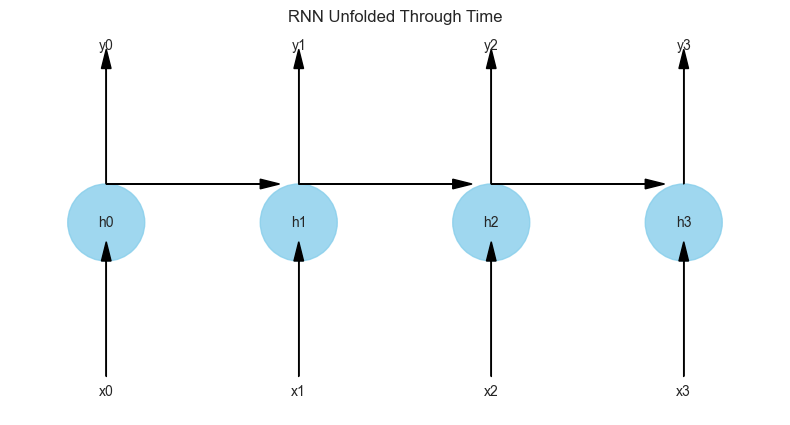

In [21]:
# Let's visualize a simple RNN unfolded through time
def plot_rnn_unfolded():
    fig, ax = plt.subplots(figsize=(12, 5))
    
    # Number of time steps to show
    t_steps = 4
    
    # Draw RNN cells
    for t in range(t_steps):
        # Hidden state circle
        circle = plt.Circle((t, 0.5), 0.2, fill=True, color='skyblue', alpha=0.8)
        ax.add_patch(circle)
        ax.text(t, 0.5, f"h{t}", ha='center', va='center')
        
        # Input
        if t > 0:  # Only show recurrent connection after first time step
            ax.arrow(t-1, 0.7, 0.8, 0, head_width=0.05, head_length=0.1, fc='black', ec='black')
        
        # Input arrow
        ax.arrow(t, -0.3, 0, 0.6, head_width=0.05, head_length=0.1, fc='black', ec='black')
        ax.text(t, -0.4, f"x{t}", ha='center')
        
        # Output arrow
        ax.arrow(t, 0.7, 0, 0.6, head_width=0.05, head_length=0.1, fc='black', ec='black')
        ax.text(t, 1.4, f"y{t}", ha='center')
    
    # Set axis properties
    ax.set_xlim(-0.5, t_steps - 0.5)
    ax.set_ylim(-0.5, 1.5)
    ax.set_aspect('equal')
    ax.axis('off')
    plt.title("RNN Unfolded Through Time")
    plt.show()
    
plot_rnn_unfolded()

### The Vanishing/Exploding Gradient Problem

A key challenge with traditional RNNs is the vanishing (or exploding) gradient problem. During backpropagation through time:

1. **Vanishing Gradients**: For long sequences, gradients may become extremely small, making learning long-term dependencies difficult.
2. **Exploding Gradients**: Gradients can also grow exponentially, causing instability during training.

These issues make it difficult for standard RNNs to capture long-term dependencies in sequences, leading to the development of more advanced architectures like LSTMs and GRUs.

## Building a Simple RNN from Scratch

Now let's implement a basic RNN cell from scratch using NumPy. We'll create a simple RNN to predict the next element in a sequence.

In [22]:
class SimpleRNNCell:
    def __init__(self, input_size, hidden_size, output_size):
        """
        Initialize an RNN cell with random weights
        
        Parameters:
        - input_size: Dimension of input features
        - hidden_size: Dimension of hidden state
        - output_size: Dimension of output
        """
        # Initialize weight matrices with Xavier/Glorot initialization
        self.Wxh = np.random.randn(hidden_size, input_size) * np.sqrt(2 / (input_size + hidden_size))
        self.Whh = np.random.randn(hidden_size, hidden_size) * np.sqrt(2 / (hidden_size + hidden_size))
        self.Why = np.random.randn(output_size, hidden_size) * np.sqrt(2 / (hidden_size + output_size))
        
        # Initialize biases
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))
        
        # For storing the values for backpropagation
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
    def forward(self, x, h_prev):
        """
        Forward pass for a single time step
        
        Parameters:
        - x: Input at current time step (input_size, 1)
        - h_prev: Hidden state from previous time step (hidden_size, 1)
        
        Returns:
        - h: New hidden state (hidden_size, 1)
        - y: Output (output_size, 1)
        """
        # Compute the hidden state
        h = np.tanh(np.dot(self.Wxh, x) + np.dot(self.Whh, h_prev) + self.bh)
        
        # Compute the output
        y = np.dot(self.Why, h) + self.by
        
        return h, y
    
    def backward(self, x, h, h_prev, dy, dh_next):
        """
        Backward pass for a single time step
        
        Parameters:
        - x: Input at current time step
        - h: Hidden state at current time step
        - h_prev: Hidden state from previous time step
        - dy: Gradient of loss with respect to output y
        - dh_next: Gradient of loss with respect to next hidden state
        
        Returns:
        - dh_prev: Gradient of loss with respect to previous hidden state
        - gradients for all parameters
        """
        # Gradient of loss with respect to Why
        dWhy = np.dot(dy, h.T)
        
        # Gradient of loss with respect to by
        dby = dy
        
        # Gradient of loss with respect to h (from output and next hidden state)
        dh = np.dot(self.Why.T, dy) + dh_next
        
        # Gradient through tanh
        dtanh = (1 - h * h) * dh
        
        # Gradients with respect to parameters
        dWxh = np.dot(dtanh, x.T)
        dWhh = np.dot(dtanh, h_prev.T)
        dbh = dtanh
        
        # Gradient with respect to previous hidden state (for backprop through time)
        dh_prev = np.dot(self.Whh.T, dtanh)
        
        # Gradient with respect to input x (not usually needed, but provided for completeness)
        dx = np.dot(self.Wxh.T, dtanh)
        
        return dh_prev, dWxh, dWhh, dWhy, dbh, dby, dx


class SimpleRNN:
    def __init__(self, input_size, hidden_size, output_size):
        """
        Initialize an RNN model
        """
        self.rnn_cell = SimpleRNNCell(input_size, hidden_size, output_size)
        self.hidden_size = hidden_size
        
    def forward(self, inputs):
        """
        Forward pass for a sequence of inputs
        
        Parameters:
        - inputs: List of inputs over time [x_0, x_1, ..., x_t]
        
        Returns:
        - outputs: List of outputs over time [y_0, y_1, ..., y_t]
        - hidden_states: List of hidden states [h_0, h_1, ..., h_t]
        """
        h = np.zeros((self.hidden_size, 1))  # Initial hidden state is zeros
        hidden_states = [h]
        outputs = []
        
        # Process each time step
        for x in inputs:
            h, y = self.rnn_cell.forward(x, h)
            hidden_states.append(h)
            outputs.append(y)
            
        return outputs, hidden_states[1:]  # Remove initial h_0
    
    def backward(self, inputs, hidden_states, outputs, targets):
        """
        Backward pass for the entire sequence
        
        Parameters:
        - inputs: List of inputs over time
        - hidden_states: List of hidden states
        - outputs: List of outputs
        - targets: List of target values
        
        Returns:
        - gradients: Dictionary of gradients for all parameters
        """
        # Initialize gradients
        T = len(inputs)
        dWxh = np.zeros_like(self.rnn_cell.Wxh)
        dWhh = np.zeros_like(self.rnn_cell.Whh)
        dWhy = np.zeros_like(self.rnn_cell.Why)
        dbh = np.zeros_like(self.rnn_cell.bh)
        dby = np.zeros_like(self.rnn_cell.by)
        
        # Initial gradient of the hidden state is zero
        dh_next = np.zeros((self.hidden_size, 1))
        
        # Go backward through time
        for t in reversed(range(T)):
            # Compute gradients of the output
            dy = outputs[t] - targets[t]
            
            # Get the previous hidden state (0 if it's the first time step)
            h_prev = np.zeros((self.hidden_size, 1)) if t == 0 else hidden_states[t-1]
            
            # Backward pass for this time step
            dh_next, dWxh_t, dWhh_t, dWhy_t, dbh_t, dby_t, _ = self.rnn_cell.backward(
                inputs[t], hidden_states[t], h_prev, dy, dh_next)
            
            # Accumulate gradients
            dWxh += dWxh_t
            dWhh += dWhh_t
            dWhy += dWhy_t
            dbh += dbh_t
            dby += dby_t
            
        # Clip gradients to prevent exploding gradients
        for grad in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(grad, -5, 5, out=grad)
            
        gradients = {
            'Wxh': dWxh, 
            'Whh': dWhh, 
            'Why': dWhy, 
            'bh': dbh, 
            'by': dby
        }
        
        return gradients
    
    def update_params(self, gradients, learning_rate):
        """
        Update parameters using gradients
        
        Parameters:
        - gradients: Dictionary of gradients
        - learning_rate: Learning rate for gradient descent
        """
        self.rnn_cell.Wxh -= learning_rate * gradients['Wxh']
        self.rnn_cell.Whh -= learning_rate * gradients['Whh']
        self.rnn_cell.Why -= learning_rate * gradients['Why']
        self.rnn_cell.bh -= learning_rate * gradients['bh']
        self.rnn_cell.by -= learning_rate * gradients['by']
        
    def train(self, X, y, epochs, learning_rate):
        """
        Train the RNN model
        
        Parameters:
        - X: List of input sequences
        - y: List of target sequences
        - epochs: Number of training epochs
        - learning_rate: Learning rate for gradient descent
        
        Returns:
        - losses: List of loss values during training
        """
        losses = []
        
        for epoch in tqdm(range(epochs), desc="Training RNN"):
            epoch_loss = 0
            
            for i in range(len(X)):
                # Forward pass
                outputs, hidden_states = self.forward(X[i])
                
                # Compute loss
                loss = 0
                for t in range(len(outputs)):
                    loss += 0.5 * np.sum((outputs[t] - y[i][t]) ** 2)
                epoch_loss += loss
                
                # Backward pass
                gradients = self.backward(X[i], hidden_states, outputs, y[i])
                
                # Update parameters
                self.update_params(gradients, learning_rate)
                
            losses.append(epoch_loss / len(X))
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {losses[-1]:.4f}")
                
        return losses

Now let's create a simple sequence prediction task to demonstrate our RNN implementation. We'll use a sine wave as our sequence data.

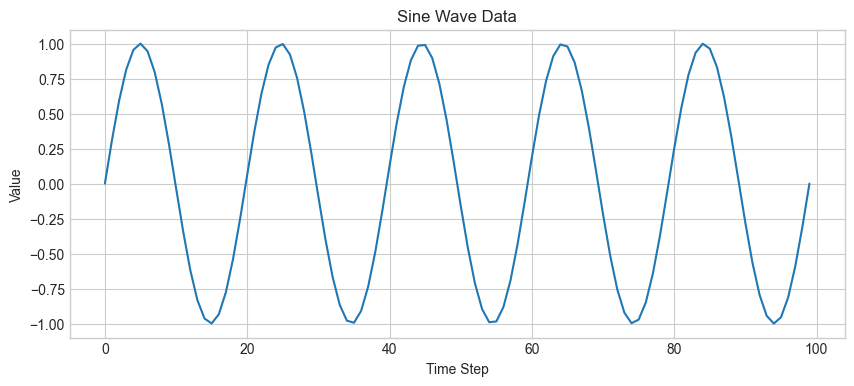

Number of training sequences: 90
Each input sequence has 10 time steps
Shape of each input at a time step: (1, 1)


In [23]:
# Generate a simple sine wave sequence
def generate_sine_wave(samples, period=20):
    x = np.linspace(0, samples/period * 2 * np.pi, samples)
    y = np.sin(x)
    return y

# Create training data for sequence prediction
def create_sequence_data(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        # Input sequence
        X_seq = [np.array([[data[i+j]]]) for j in range(seq_length)]
        
        # Target sequence (next values after each input)
        y_seq = [np.array([[data[i+j+1]]]) for j in range(seq_length)]
        
        X.append(X_seq)
        y.append(y_seq)
    return X, y

# Generate data
samples = 100
sine_wave = generate_sine_wave(samples)

# Plot the sine wave
plt.figure(figsize=(10, 4))
plt.plot(sine_wave)
plt.title("Sine Wave Data")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.grid(True)
plt.show()

# Create sequences
seq_length = 10
X, y = create_sequence_data(sine_wave, seq_length)

print(f"Number of training sequences: {len(X)}")
print(f"Each input sequence has {seq_length} time steps")
print(f"Shape of each input at a time step: {X[0][0].shape}")

Training RNN:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0, Loss: 0.1753
Epoch 10, Loss: 0.0842
Epoch 20, Loss: 0.0758
Epoch 30, Loss: 0.0696
Epoch 40, Loss: 0.0654
Epoch 50, Loss: 0.0620
Epoch 60, Loss: 0.0591
Epoch 70, Loss: 0.0563
Epoch 80, Loss: 0.0535
Epoch 90, Loss: 0.0507


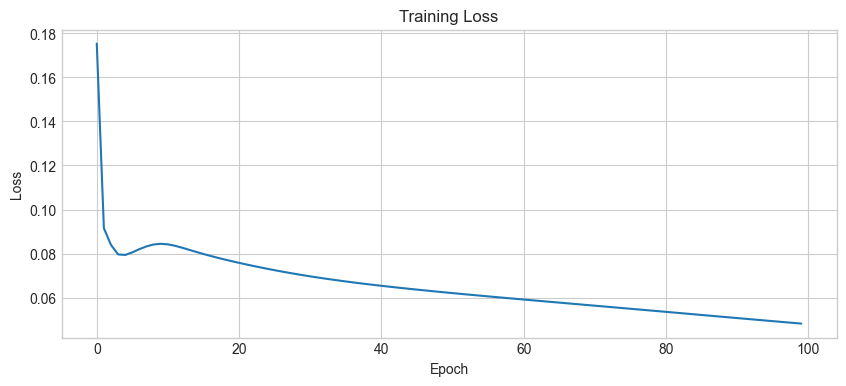

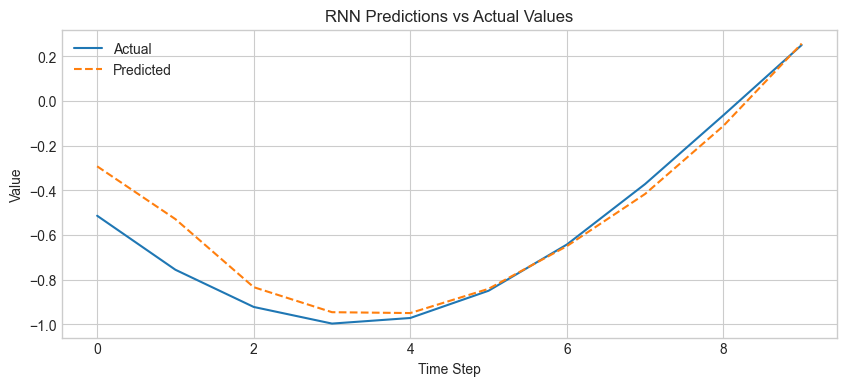

In [24]:
# Train our custom RNN model on the sine wave data
input_size = 1   # Dimension of input (sine wave value)
hidden_size = 16  # Dimension of hidden state
output_size = 1  # Dimension of output (predicted next value)

# Create and train the model
rnn_model = SimpleRNN(input_size, hidden_size, output_size)
losses = rnn_model.train(X[:70], y[:70], epochs=100, learning_rate=0.01)

# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Test the model
test_predictions = []
test_seq = X[70]  # Use one of the test sequences

# Make predictions
outputs, _ = rnn_model.forward(test_seq)
predictions = [output[0][0] for output in outputs]

# Plot results
plt.figure(figsize=(10, 4))
plt.plot([y[0][0] for y in y[70]], label="Actual")
plt.plot(predictions, label="Predicted", linestyle='--')
plt.title("RNN Predictions vs Actual Values")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

## Using Built-in RNNs in Frameworks

Now let's see how to implement the same task using PyTorch's built-in RNN module.

In [25]:
# Prepare data for PyTorch
def create_torch_dataset(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+1:i+seq_length+1])
    
    return torch.FloatTensor(np.array(X)).unsqueeze(-1), torch.FloatTensor(np.array(y)).unsqueeze(-1)

# Create the dataset
X_torch, y_torch = create_torch_dataset(sine_wave, seq_length)

# Split into train and test
train_size = 70
X_train = X_torch[:train_size]
y_train = y_torch[:train_size]
X_test = X_torch[train_size:]
y_test = y_torch[train_size:]

print(f"X_train shape: {X_train.shape}")  # [batch_size, sequence_length, input_size]
print(f"y_train shape: {y_train.shape}")  # [batch_size, sequence_length, output_size]

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

X_train shape: torch.Size([70, 10, 1])
y_train shape: torch.Size([70, 10, 1])


In [26]:
# Define the PyTorch RNN model
class PyTorchRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PyTorchRNN, self).__init__()
        self.hidden_size = hidden_size
        
        # RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        
        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Initial hidden state (batch_size, hidden_size)
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        
        # Forward pass through RNN
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        out, _ = self.rnn(x, h0)
        
        # Decode the hidden state for each time step
        out = self.fc(out)
        return out

# Create the model
input_size = 1
hidden_size = 16
output_size = 1

model = PyTorchRNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

Training PyTorch RNN:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0, Loss: 0.3579
Epoch 10, Loss: 0.0173
Epoch 20, Loss: 0.0156
Epoch 30, Loss: 0.0158
Epoch 40, Loss: 0.0143
Epoch 50, Loss: 0.0132
Epoch 60, Loss: 0.0135
Epoch 70, Loss: 0.0118
Epoch 80, Loss: 0.0111
Epoch 90, Loss: 0.0112


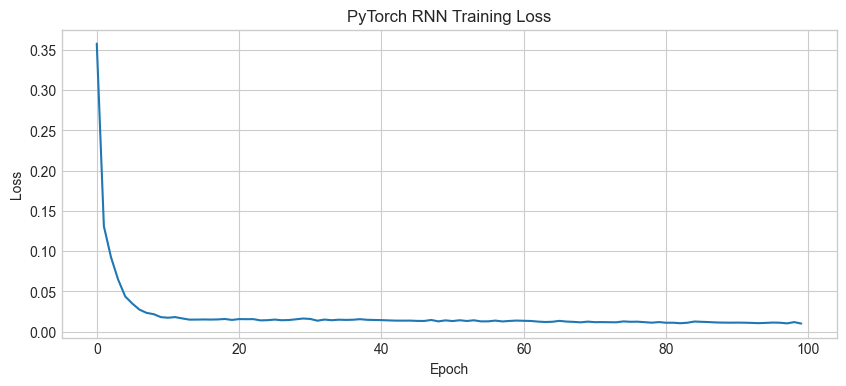

In [27]:
# Train the PyTorch RNN model
epochs = 100
losses = []

for epoch in tqdm(range(epochs), desc="Training PyTorch RNN"):
    model.train()
    epoch_loss = 0
    
    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")

# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.title("PyTorch RNN Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

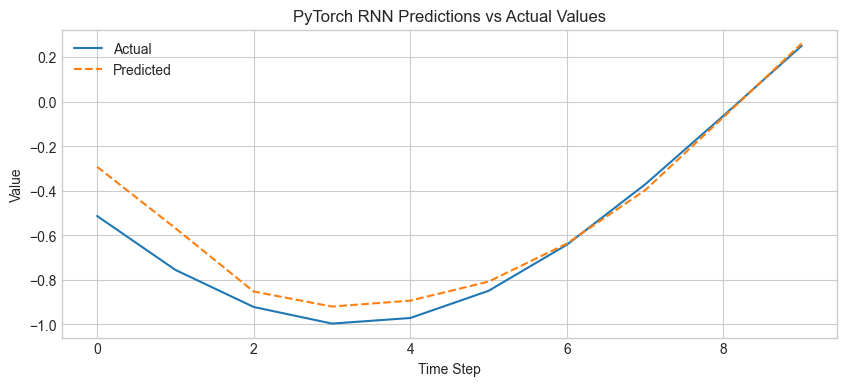

In [28]:
# Evaluate the model
model.eval()
with torch.no_grad():
    test_sample = X_test[0].unsqueeze(0)  # Add batch dimension
    prediction = model(test_sample).squeeze()
    actual = y_test[0].squeeze()
    
    # Plot results
    plt.figure(figsize=(10, 4))
    plt.plot(actual.numpy(), label="Actual")
    plt.plot(prediction.numpy(), label="Predicted", linestyle='--')
    plt.title("PyTorch RNN Predictions vs Actual Values")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

## Understanding LSTMs

Long Short-Term Memory (LSTM) networks are a type of RNN specifically designed to address the vanishing gradient problem that affects standard RNNs. They can effectively capture long-term dependencies in sequential data.

### Key Components of an LSTM Cell:

1. **Cell State (C_t)**: The main memory pipeline that runs through the entire sequence.
2. **Hidden State (h_t)**: Output state at each time step that is passed to the next cell.
3. **Gates**:
   - **Forget Gate**: Decides what information to discard from the cell state.
   - **Input Gate**: Decides which new information to add to the cell state.
   - **Output Gate**: Controls what part of the cell state to output.

### LSTM Cell Equations:

1. **Forget Gate**: f_t = σ(W_f · [h_{t-1}, x_t] + b_f)
2. **Input Gate**: i_t = σ(W_i · [h_{t-1}, x_t] + b_i)
3. **Candidate Cell State**: C̃_t = tanh(W_C · [h_{t-1}, x_t] + b_C)
4. **Cell State Update**: C_t = f_t * C_{t-1} + i_t * C̃_t
5. **Output Gate**: o_t = σ(W_o · [h_{t-1}, x_t] + b_o)
6. **Hidden State**: h_t = o_t * tanh(C_t)

Where σ is the sigmoid function and * denotes element-wise multiplication.

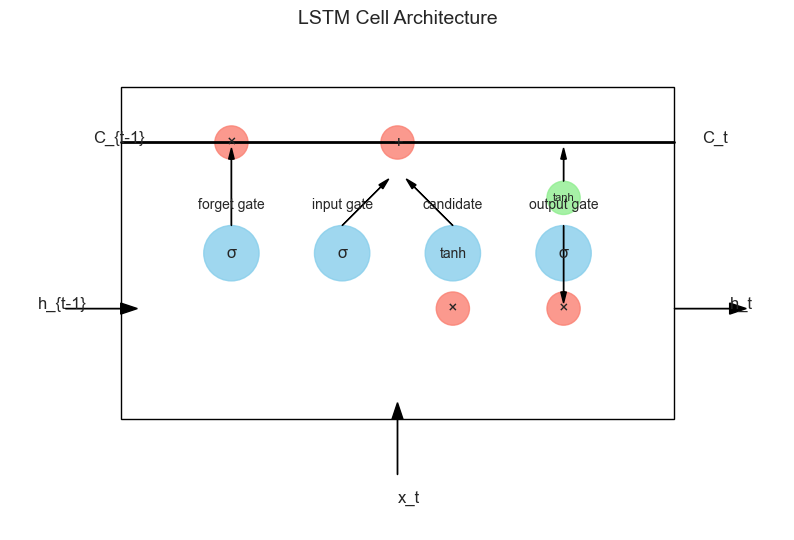

In [29]:
# Visualize LSTM architecture
def plot_lstm_cell():
    fig, ax = plt.subplots(figsize=(10, 7))
    
    # Cell box
    ax.add_patch(plt.Rectangle((0, 0), 10, 6, fill=False, edgecolor='black'))
    
    # Cell state line (C_t)
    ax.plot([0, 10], [5, 5], 'k-', linewidth=2)
    ax.text(-0.5, 5, "C_{t-1}", fontsize=12)
    ax.text(10.5, 5, "C_t", fontsize=12)
    
    # Hidden state input/output
    ax.arrow(-1, 2, 1, 0, head_width=0.2, head_length=0.3, fc='black', ec='black')
    ax.text(-1.5, 2, "h_{t-1}", fontsize=12)
    ax.arrow(10, 2, 1, 0, head_width=0.2, head_length=0.3, fc='black', ec='black')
    ax.text(11, 2, "h_t", fontsize=12)
    
    # Input
    ax.arrow(5, -1, 0, 1, head_width=0.2, head_length=0.3, fc='black', ec='black')
    ax.text(5, -1.5, "x_t", fontsize=12)
    
    # Gates
    # Forget gate
    ax.add_patch(plt.Circle((2, 3), 0.5, fill=True, color='skyblue', alpha=0.8))
    ax.text(2, 3, "σ", ha='center', va='center', fontsize=12)
    ax.text(2, 3.8, "forget gate", ha='center', fontsize=10)
    
    # Input gate
    ax.add_patch(plt.Circle((4, 3), 0.5, fill=True, color='skyblue', alpha=0.8))
    ax.text(4, 3, "σ", ha='center', va='center', fontsize=12)
    ax.text(4, 3.8, "input gate", ha='center', fontsize=10)
    
    # Candidate
    ax.add_patch(plt.Circle((6, 3), 0.5, fill=True, color='skyblue', alpha=0.8))
    ax.text(6, 3, "tanh", ha='center', va='center', fontsize=10)
    ax.text(6, 3.8, "candidate", ha='center', fontsize=10)
    
    # Output gate
    ax.add_patch(plt.Circle((8, 3), 0.5, fill=True, color='skyblue', alpha=0.8))
    ax.text(8, 3, "σ", ha='center', va='center', fontsize=12)
    ax.text(8, 3.8, "output gate", ha='center', fontsize=10)
    
    # Operations
    ax.add_patch(plt.Circle((2, 5), 0.3, fill=True, color='salmon', alpha=0.8))
    ax.text(2, 5, "×", ha='center', va='center', fontsize=12)
    
    ax.add_patch(plt.Circle((5, 5), 0.3, fill=True, color='salmon', alpha=0.8))
    ax.text(5, 5, "+", ha='center', va='center', fontsize=12)
    
    ax.add_patch(plt.Circle((6, 2), 0.3, fill=True, color='salmon', alpha=0.8))
    ax.text(6, 2, "×", ha='center', va='center', fontsize=12)
    
    ax.add_patch(plt.Circle((8, 2), 0.3, fill=True, color='salmon', alpha=0.8))
    ax.text(8, 2, "×", ha='center', va='center', fontsize=12)
    
    ax.add_patch(plt.Circle((8, 4), 0.3, fill=True, color='lightgreen', alpha=0.8))
    ax.text(8, 4, "tanh", ha='center', va='center', fontsize=8)
    
    # Connect elements with arrows
    # Forget gate connections
    ax.arrow(2, 3.5, 0, 1.2, head_width=0.1, head_length=0.2, fc='black', ec='black')
    
    # Input gate connections
    ax.arrow(4, 3.5, 0.7, 0.7, head_width=0.1, head_length=0.2, fc='black', ec='black')
    ax.arrow(6, 3.5, -0.7, 0.7, head_width=0.1, head_length=0.2, fc='black', ec='black')
    
    # Output gate connections
    ax.arrow(8, 3.5, 0, -1.2, head_width=0.1, head_length=0.2, fc='black', ec='black')
    ax.arrow(8, 4.3, 0, 0.4, head_width=0.1, head_length=0.2, fc='black', ec='black')
    
    # Set axis properties
    ax.set_xlim(-2, 12)
    ax.set_ylim(-2, 7)
    ax.set_aspect('equal')
    ax.axis('off')
    plt.title("LSTM Cell Architecture", fontsize=14)
    plt.show()
    
plot_lstm_cell()

## Building an LSTM from Scratch

Now let's implement an LSTM cell from scratch using NumPy, similar to how we built the simple RNN.

In [30]:
class LSTMCell:
    def __init__(self, input_size, hidden_size):
        """
        Initialize an LSTM cell with random weights
        
        Parameters:
        - input_size: Dimension of input features
        - hidden_size: Dimension of hidden state and cell state
        """
        # Xavier/Glorot initialization for better convergence
        scale = np.sqrt(2.0 / (input_size + hidden_size))
        
        # Forget gate weights and bias
        self.Wf = np.random.randn(hidden_size, input_size + hidden_size) * scale
        self.bf = np.zeros((hidden_size, 1))
        
        # Input gate weights and bias
        self.Wi = np.random.randn(hidden_size, input_size + hidden_size) * scale
        self.bi = np.zeros((hidden_size, 1))
        
        # Cell candidate weights and bias
        self.Wc = np.random.randn(hidden_size, input_size + hidden_size) * scale
        self.bc = np.zeros((hidden_size, 1))
        
        # Output gate weights and bias
        self.Wo = np.random.randn(hidden_size, input_size + hidden_size) * scale
        self.bo = np.zeros((hidden_size, 1))
        
        # For storing the intermediate values for backpropagation
        self.input_size = input_size
        self.hidden_size = hidden_size
    
    def forward(self, x, h_prev, c_prev):
        """
        Forward pass for a single time step
        
        Parameters:
        - x: Input at current time step (input_size, 1)
        - h_prev: Hidden state from previous time step (hidden_size, 1)
        - c_prev: Cell state from previous time step (hidden_size, 1)
        
        Returns:
        - h: New hidden state (hidden_size, 1)
        - c: New cell state (hidden_size, 1)
        - cache: Cache of values for backpropagation
        """
        # Concatenate input and previous hidden state
        xh = np.vstack((x, h_prev))
        
        # Forget gate
        f_gate = self.sigmoid(np.dot(self.Wf, xh) + self.bf)
        
        # Input gate
        i_gate = self.sigmoid(np.dot(self.Wi, xh) + self.bi)
        
        # Cell candidate
        c_candidate = np.tanh(np.dot(self.Wc, xh) + self.bc)
        
        # Output gate
        o_gate = self.sigmoid(np.dot(self.Wo, xh) + self.bo)
        
        # New cell state
        c = f_gate * c_prev + i_gate * c_candidate
        
        # New hidden state
        h = o_gate * np.tanh(c)
        
        # Cache for backward pass
        cache = {
            'xh': xh, 
            'f_gate': f_gate, 
            'i_gate': i_gate, 
            'c_candidate': c_candidate, 
            'o_gate': o_gate, 
            'c_prev': c_prev, 
            'c': c, 
            'tanh_c': np.tanh(c)
        }
        
        return h, c, cache
    
    def backward(self, dh, dc_next, cache):
        """
        Backward pass for a single time step
        
        Parameters:
        - dh: Gradient of loss with respect to hidden state h
        - dc_next: Gradient of loss with respect to next cell state
        - cache: Cache from forward pass
        
        Returns:
        - dx: Gradient of loss with respect to input x
        - dh_prev: Gradient of loss with respect to previous hidden state
        - dc_prev: Gradient of loss with respect to previous cell state
        - gradients for all parameters
        """
        # Unpack cache
        xh = cache['xh']
        f_gate = cache['f_gate']
        i_gate = cache['i_gate']
        c_candidate = cache['c_candidate']
        o_gate = cache['o_gate']
        c_prev = cache['c_prev']
        c = cache['c']
        tanh_c = cache['tanh_c']
        
        # Split xh into x and h_prev
        x = xh[:self.input_size]
        h_prev = xh[self.input_size:]
        
        # Gradient through the hidden state equation
        do = dh * tanh_c
        dc = dc_next + dh * o_gate * (1 - tanh_c**2)
        
        # Gradient through the cell state equation
        df = dc * c_prev
        dc_prev = dc * f_gate
        di = dc * c_candidate
        dc_candidate = dc * i_gate
        
        # Gradient through the activation functions
        do_input = do * o_gate * (1 - o_gate)
        df_input = df * f_gate * (1 - f_gate)
        di_input = di * i_gate * (1 - i_gate)
        dc_candidate_input = dc_candidate * (1 - c_candidate**2)
        
        # Gradient with respect to weights and biases
        dWo = np.dot(do_input, xh.T)
        dbo = do_input
        dWf = np.dot(df_input, xh.T)
        dbf = df_input
        dWi = np.dot(di_input, xh.T)
        dbi = di_input
        dWc = np.dot(dc_candidate_input, xh.T)
        dbc = dc_candidate_input
        
        # Gradient with respect to xh
        dxh = np.dot(self.Wo.T, do_input) + \
              np.dot(self.Wf.T, df_input) + \
              np.dot(self.Wi.T, di_input) + \
              np.dot(self.Wc.T, dc_candidate_input)
        
        # Split dxh to get gradients for input and previous hidden state
        dx = dxh[:self.input_size]
        dh_prev = dxh[self.input_size:]
        
        gradients = {
            'Wf': dWf, 'bf': dbf,
            'Wi': dWi, 'bi': dbi,
            'Wc': dWc, 'bc': dbc,
            'Wo': dWo, 'bo': dbo
        }
        
        return dx, dh_prev, dc_prev, gradients
    
    def sigmoid(self, x):
        """Sigmoid activation function"""
        return 1 / (1 + np.exp(-np.clip(x, -15, 15)))  # Clip to avoid overflow


class LSTM:
    def __init__(self, input_size, hidden_size, output_size):
        """
        Initialize an LSTM model
        
        Parameters:
        - input_size: Dimension of input features
        - hidden_size: Dimension of hidden state
        - output_size: Dimension of output
        """
        self.lstm_cell = LSTMCell(input_size, hidden_size)
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # Output layer parameters
        self.Why = np.random.randn(output_size, hidden_size) * np.sqrt(2.0 / (hidden_size + output_size))
        self.by = np.zeros((output_size, 1))
        
    def forward(self, inputs):
        """
        Forward pass for a sequence of inputs
        
        Parameters:
        - inputs: List of inputs over time [x_0, x_1, ..., x_t]
        
        Returns:
        - outputs: List of outputs over time [y_0, y_1, ..., y_t]
        - hidden_states: List of hidden states over time [h_0, h_1, ..., h_t]
        - cell_states: List of cell states over time [c_0, c_1, ..., c_t]
        - caches: List of caches for backpropagation
        """
        h = np.zeros((self.hidden_size, 1))  # Initial hidden state
        c = np.zeros((self.hidden_size, 1))  # Initial cell state
        
        hidden_states = []
        cell_states = []
        outputs = []
        caches = []
        
        # Process each time step
        for x in inputs:
            h, c, cache = self.lstm_cell.forward(x, h, c)
            y = np.dot(self.Why, h) + self.by  # Output layer
            
            hidden_states.append(h)
            cell_states.append(c)
            outputs.append(y)
            caches.append(cache)
        
        return outputs, hidden_states, cell_states, caches
    
    def backward(self, inputs, hidden_states, cell_states, outputs, targets, caches):
        """
        Backward pass for the entire sequence
        
        Parameters:
        - inputs: List of inputs over time
        - hidden_states: List of hidden states over time
        - cell_states: List of cell states over time
        - outputs: List of outputs over time
        - targets: List of target values over time
        - caches: List of caches from the forward pass
        
        Returns:
        - gradients: Dictionary of gradients for all parameters
        """
        # Initialize gradients
        T = len(inputs)
        dWhy = np.zeros_like(self.Why)
        dby = np.zeros_like(self.by)
        
        dWf = np.zeros_like(self.lstm_cell.Wf)
        dbf = np.zeros_like(self.lstm_cell.bf)
        dWi = np.zeros_like(self.lstm_cell.Wi)
        dbi = np.zeros_like(self.lstm_cell.bi)
        dWc = np.zeros_like(self.lstm_cell.Wc)
        dbc = np.zeros_like(self.lstm_cell.bc)
        dWo = np.zeros_like(self.lstm_cell.Wo)
        dbo = np.zeros_like(self.lstm_cell.bo)
        
        dh_next = np.zeros((self.hidden_size, 1))
        dc_next = np.zeros((self.hidden_size, 1))
        
        # Go backward through time
        for t in reversed(range(T)):
            # Gradient of the output layer
            dy = outputs[t] - targets[t]
            dWhy += np.dot(dy, hidden_states[t].T)
            dby += dy
            
            # Gradient flowing back from the output layer to hidden state
            dh = np.dot(self.Why.T, dy) + dh_next
            
            # Backpropagate through the LSTM cell
            if t > 0:
                dx, dh_next, dc_next, cell_grads = self.lstm_cell.backward(
                    dh, dc_next, caches[t])
            else:
                dx, dh_next, dc_next, cell_grads = self.lstm_cell.backward(
                    dh, dc_next, caches[t])
            
            # Accumulate gradients for LSTM cell parameters
            dWf += cell_grads['Wf']
            dbf += cell_grads['bf']
            dWi += cell_grads['Wi']
            dbi += cell_grads['bi']
            dWc += cell_grads['Wc']
            dbc += cell_grads['bc']
            dWo += cell_grads['Wo']
            dbo += cell_grads['bo']
            
        # Clip gradients to prevent exploding gradients
        for grad in [dWf, dbf, dWi, dbi, dWc, dbc, dWo, dbo, dWhy, dby]:
            np.clip(grad, -5, 5, out=grad)
            
        gradients = {
            'Why': dWhy, 'by': dby,
            'Wf': dWf, 'bf': dbf,
            'Wi': dWi, 'bi': dbi,
            'Wc': dWc, 'bc': dbc,
            'Wo': dWo, 'bo': dbo
        }
        
        return gradients
    
    def update_params(self, gradients, learning_rate):
        """
        Update parameters using gradients
        
        Parameters:
        - gradients: Dictionary of gradients
        - learning_rate: Learning rate for gradient descent
        """
        # Update output layer parameters
        self.Why -= learning_rate * gradients['Why']
        self.by -= learning_rate * gradients['by']
        
        # Update LSTM cell parameters
        self.lstm_cell.Wf -= learning_rate * gradients['Wf']
        self.lstm_cell.bf -= learning_rate * gradients['bf']
        self.lstm_cell.Wi -= learning_rate * gradients['Wi']
        self.lstm_cell.bi -= learning_rate * gradients['bi']
        self.lstm_cell.Wc -= learning_rate * gradients['Wc']
        self.lstm_cell.bc -= learning_rate * gradients['bc']
        self.lstm_cell.Wo -= learning_rate * gradients['Wo']
        self.lstm_cell.bo -= learning_rate * gradients['bo']
    
    def train(self, X, y, epochs, learning_rate):
        """
        Train the LSTM model
        
        Parameters:
        - X: List of input sequences
        - y: List of target sequences
        - epochs: Number of training epochs
        - learning_rate: Learning rate for gradient descent
        
        Returns:
        - losses: List of loss values during training
        """
        losses = []
        
        for epoch in tqdm(range(epochs), desc="Training LSTM"):
            epoch_loss = 0
            
            for i in range(len(X)):
                # Forward pass
                outputs, hidden_states, cell_states, caches = self.forward(X[i])
                
                # Compute loss
                loss = 0
                for t in range(len(outputs)):
                    loss += 0.5 * np.sum((outputs[t] - y[i][t]) ** 2)
                epoch_loss += loss
                
                # Backward pass
                gradients = self.backward(X[i], hidden_states, cell_states, outputs, y[i], caches)
                
                # Update parameters
                self.update_params(gradients, learning_rate)
                
            losses.append(epoch_loss / len(X))
            
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {losses[-1]:.4f}")
                
        return losses

Training LSTM:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 0, Loss: 1.4436
Epoch 10, Loss: 0.1283
Epoch 20, Loss: 0.1020
Epoch 30, Loss: 0.0887
Epoch 40, Loss: 0.0808
Epoch 50, Loss: 0.0752
Epoch 60, Loss: 0.0706
Epoch 70, Loss: 0.0664


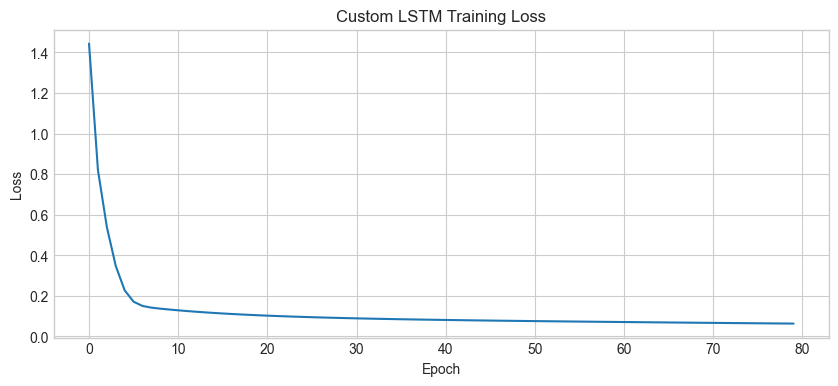

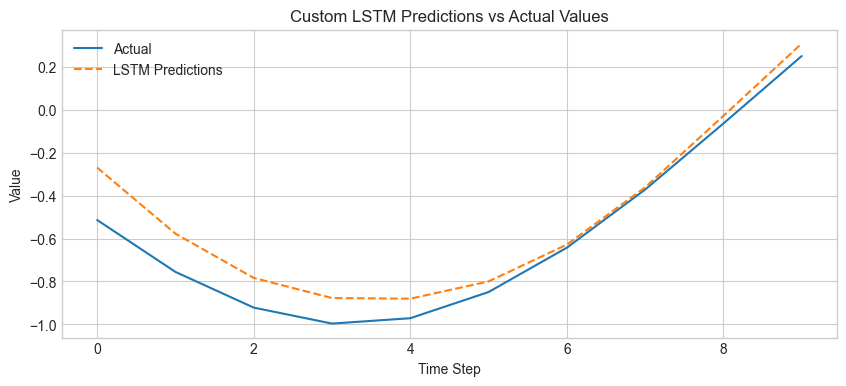

In [31]:
# Train our custom LSTM model on the sine wave data
input_size = 1
hidden_size = 16
output_size = 1

# Create and train the model
lstm_model = LSTM(input_size, hidden_size, output_size)
lstm_losses = lstm_model.train(X[:70], y[:70], epochs=80, learning_rate=0.005)

# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(lstm_losses)
plt.title("Custom LSTM Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Test the model
test_seq = X[70]
outputs, _, _, _ = lstm_model.forward(test_seq)
lstm_predictions = [output[0][0] for output in outputs]

# Plot results
plt.figure(figsize=(10, 4))
plt.plot([y[0][0] for y in y[70]], label="Actual")
plt.plot(lstm_predictions, label="LSTM Predictions", linestyle='--')
plt.title("Custom LSTM Predictions vs Actual Values")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

## Using Built-in LSTMs in Frameworks

Now we'll implement the same task using PyTorch's built-in LSTM module.

In [32]:
# Define the PyTorch LSTM model
class PyTorchLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PyTorchLSTM, self).__init__()
        self.hidden_size = hidden_size
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        
        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Forward pass through LSTM
        # x shape: (batch_size, seq_length, input_size)
        # h0 and c0 shapes: (num_layers, batch_size, hidden_size)
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        
        # Decode the hidden state for each time step
        out = self.fc(out)
        return out

# Create the PyTorch LSTM model
lstm_model_pt = PyTorchLSTM(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model_pt.parameters(), lr=0.01)

Training PyTorch LSTM:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0, Loss: 0.4860
Epoch 10, Loss: 0.0195
Epoch 20, Loss: 0.0092
Epoch 30, Loss: 0.0076
Epoch 40, Loss: 0.0067
Epoch 50, Loss: 0.0060
Epoch 60, Loss: 0.0061
Epoch 70, Loss: 0.0057
Epoch 80, Loss: 0.0051
Epoch 90, Loss: 0.0051


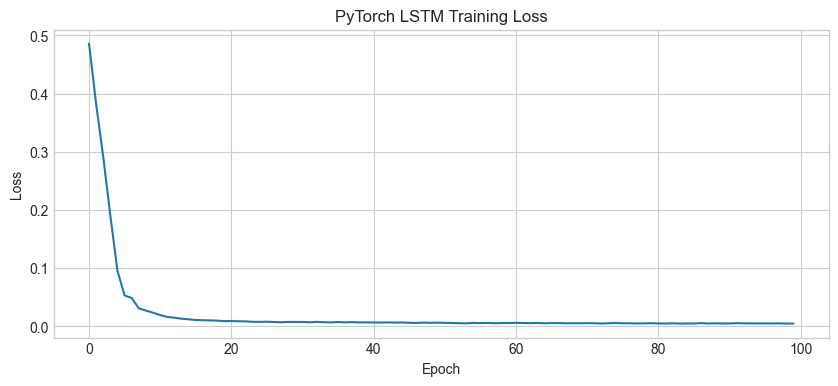

In [33]:
# Train the PyTorch LSTM model
epochs = 100
pt_lstm_losses = []

for epoch in tqdm(range(epochs), desc="Training PyTorch LSTM"):
    lstm_model_pt.train()
    epoch_loss = 0
    
    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = lstm_model_pt(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    pt_lstm_losses.append(avg_loss)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")

# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(pt_lstm_losses)
plt.title("PyTorch LSTM Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

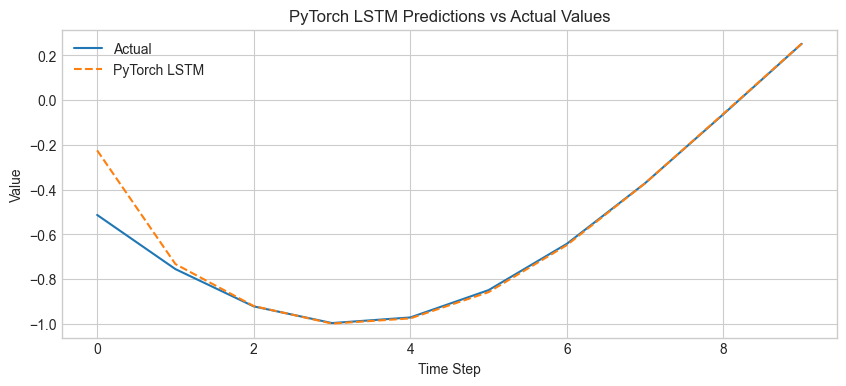

In [34]:
# Evaluate the PyTorch LSTM model
lstm_model_pt.eval()
with torch.no_grad():
    test_sample = X_test[0].unsqueeze(0)
    prediction = lstm_model_pt(test_sample).squeeze()
    actual = y_test[0].squeeze()
    
    # Plot results
    plt.figure(figsize=(10, 4))
    plt.plot(actual.numpy(), label="Actual")
    plt.plot(prediction.numpy(), label="PyTorch LSTM", linestyle='--')
    plt.title("PyTorch LSTM Predictions vs Actual Values")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

## Comparing RNN and LSTM Performance

Now let's compare the performance of vanilla RNNs and LSTMs on sequences of varying lengths to demonstrate how LSTMs are better at capturing long-term dependencies.

In [35]:
# Generate datasets with different sequence lengths
def generate_data_with_lag(samples, period=20, lag=5):
    """Generate a sine wave with a lagged pattern to test memory capabilities"""
    x = np.linspace(0, samples/period * 2 * np.pi, samples)
    y = np.sin(x)
    
    # Create inputs and targets with a specific lag
    X, y_target = [], []
    for i in range(samples - lag):
        X.append(y[i])
        y_target.append(y[i + lag])  # Target is 'lag' steps ahead
    
    return np.array(X), np.array(y_target)

# Generate data with different lags
lags = [5, 10, 20, 40]
datasets = []

for lag in lags:
    X, y_target = generate_data_with_lag(200, lag=lag)
    # Reshape for PyTorch models
    X_torch = torch.FloatTensor(X).unsqueeze(-1)
    y_torch = torch.FloatTensor(y_target).unsqueeze(-1)
    
    # Split into train and test
    train_size = int(len(X) * 0.7)
    X_train, X_test = X_torch[:train_size], X_torch[train_size:]
    y_train, y_test = y_torch[:train_size], y_torch[train_size:]
    
    datasets.append((X_train, y_train, X_test, y_test, lag))

In [36]:
# Function to train and evaluate models
def train_and_evaluate_model(model_type, X_train, y_train, X_test, y_test, epochs=100):
    input_size = 1
    hidden_size = 16
    output_size = 1
    
    if model_type == "RNN":
        model = nn.RNN(input_size, hidden_size, batch_first=True)
    else:  # LSTM
        model = nn.LSTM(input_size, hidden_size, batch_first=True)
    
    # Create a complete model with linear output layer
    class SequenceModel(nn.Module):
        def __init__(self, rnn_layer):
            super().__init__()
            self.rnn = rnn_layer
            self.hidden_size = hidden_size
            self.fc = nn.Linear(hidden_size, output_size)
            
        def forward(self, x):
            # Reshape input for single time step prediction: [batch_size, 1, input_size]
            x = x.unsqueeze(1)
            
            # Initial hidden states
            if isinstance(self.rnn, nn.LSTM):
                h0 = torch.zeros(1, x.size(0), self.hidden_size)
                c0 = torch.zeros(1, x.size(0), self.hidden_size)
                out, _ = self.rnn(x, (h0, c0))
            else:
                h0 = torch.zeros(1, x.size(0), self.hidden_size)
                out, _ = self.rnn(x, h0)
            
            # Apply output layer to the last hidden state
            out = self.fc(out.squeeze(1))
            return out
    
    full_model = SequenceModel(model)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(full_model.parameters(), lr=0.01)
    
    # Create DataLoaders
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    # Train the model
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = full_model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        losses.append(epoch_loss / len(train_loader))
    
    # Evaluate on test set
    full_model.eval()
    with torch.no_grad():
        test_predictions = full_model(X_test)
        test_loss = criterion(test_predictions, y_test).item()
    
    return test_loss, full_model

# Train and evaluate models for different lags
results = []

for X_train, y_train, X_test, y_test, lag in datasets:
    # Train RNN
    rnn_loss, rnn_model = train_and_evaluate_model("RNN", X_train, y_train, X_test, y_test)
    
    # Train LSTM
    lstm_loss, lstm_model = train_and_evaluate_model("LSTM", X_train, y_train, X_test, y_test)
    
    results.append({
        "lag": lag,
        "rnn_loss": rnn_loss,
        "lstm_loss": lstm_loss
    })
    print(f"Lag {lag}: RNN Test Loss: {rnn_loss:.4f}, LSTM Test Loss: {lstm_loss:.4f}")

Lag 5: RNN Test Loss: 0.5054, LSTM Test Loss: 0.5061
Lag 10: RNN Test Loss: 0.0002, LSTM Test Loss: 0.0004
Lag 20: RNN Test Loss: 0.0006, LSTM Test Loss: 0.0008
Lag 40: RNN Test Loss: 0.0021, LSTM Test Loss: 0.0024


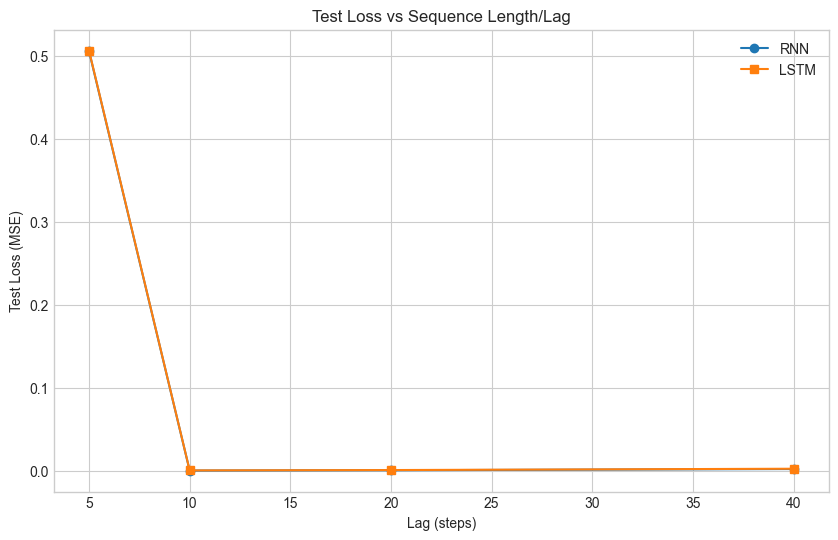

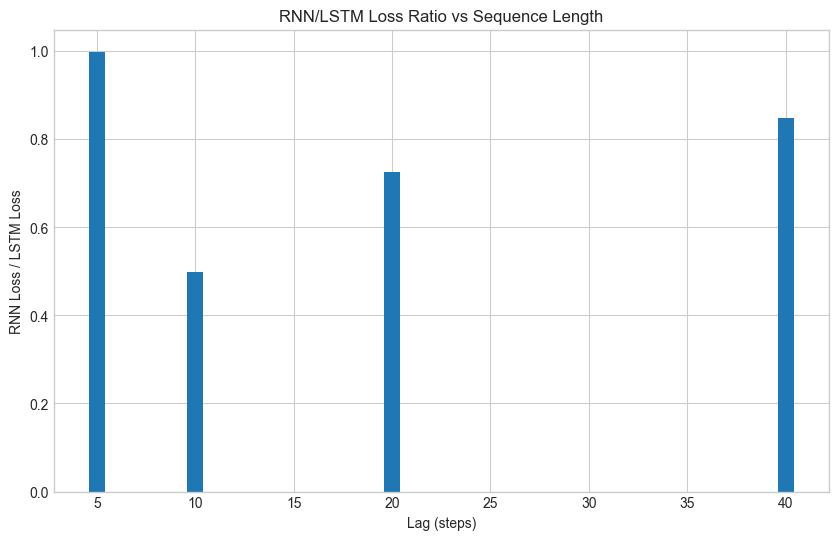

In [37]:
# Plot comparison of RNN vs LSTM for different lags
rnn_losses = [result["rnn_loss"] for result in results]
lstm_losses = [result["lstm_loss"] for result in results]
lag_values = [result["lag"] for result in results]

plt.figure(figsize=(10, 6))
plt.plot(lag_values, rnn_losses, 'o-', label='RNN')
plt.plot(lag_values, lstm_losses, 's-', label='LSTM')
plt.title("Test Loss vs Sequence Length/Lag")
plt.xlabel("Lag (steps)")
plt.ylabel("Test Loss (MSE)")
plt.grid(True)
plt.legend()
plt.show()

# Calculate and display the ratio of RNN loss to LSTM loss
loss_ratio = [rnn/lstm for rnn, lstm in zip(rnn_losses, lstm_losses)]

plt.figure(figsize=(10, 6))
plt.bar(lag_values, loss_ratio)
plt.title("RNN/LSTM Loss Ratio vs Sequence Length")
plt.xlabel("Lag (steps)")
plt.ylabel("RNN Loss / LSTM Loss")
plt.grid(True)
plt.show()

## Practical Application: Text Generation

For a practical application, let's implement a character-level language model using both RNN and LSTM to generate text. We'll train on a sample text corpus and compare the quality of generated text from both models.

In [38]:
# Sample text data for training
text_sample = """
The quick brown fox jumps over the lazy dog. This pangram contains all the letters of the English alphabet. 
How vexingly quick daft zebras jump! Pack my box with five dozen liquor jugs. Crazy Fredrick bought many very exquisite opal jewels. 
The five boxing wizards jump quickly. The jay, pig, fox, zebra, and my wolves quack! A mad boxer shot a quick, gloved jab to the jaw of his dizzy opponent.
Jaded zombies acted quaintly but kept driving their oxen forward. Sphinx of black quartz, judge my vow.
"""

# Character-level processing
chars = sorted(list(set(text_sample)))
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

print(f"Total unique characters: {len(chars)}")
print(f"Sample characters: {chars[:10]}")

# Create training data for character-level language model
def create_char_sequences(text, seq_length):
    X = []
    y = []
    for i in range(0, len(text) - seq_length):
        # Input is sequence of characters
        seq_in = text[i:i + seq_length]
        # Target is the next character
        seq_out = text[i + seq_length]
        
        # Convert to indices
        X.append([char_to_idx[char] for char in seq_in])
        y.append(char_to_idx[seq_out])
    
    # Convert to one-hot encoding for targets
    n_chars = len(chars)
    X_tensor = torch.LongTensor(X)
    y_tensor = torch.LongTensor(y)
    
    return X_tensor, y_tensor, n_chars

# Sequence length for training
seq_length = 20

# Create training data
X_chars, y_chars, n_chars = create_char_sequences(text_sample, seq_length)

print(f"X shape: {X_chars.shape}")
print(f"y shape: {y_chars.shape}")

Total unique characters: 40
Sample characters: ['\n', ' ', '!', ',', '.', 'A', 'C', 'E', 'F', 'H']
X shape: torch.Size([484, 20])
y shape: torch.Size([484])
